# Import necessary libraries

In [8]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as r 

from collections import defaultdict, deque
from dataclasses import dataclass, field
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Code to combine datasets from multiple seasons

In [10]:
#Find the common columns between 2021-11.csv and 2021-2022.csv
cols1 = set(pd.read_csv("Datasets/2009-10.csv", nrows=0).columns)
cols2 = set(pd.read_csv("Datasets/2021-2022.csv", nrows=0).columns)
common_cols = sorted(cols1 & cols2)

print(f"Using {len(common_cols)} common columns:\n{common_cols}\n")

list_of_files = [
    "Datasets/2009-10.csv",
    "Datasets/2010-11.csv",
    "Datasets/2011-12.csv",
    "Datasets/2012-13.csv",
    "Datasets/2013-14.csv",
    "Datasets/2014-15.csv",
    "Datasets/2015-16.csv",
    "Datasets/2016-17.csv",
    "Datasets/2017-18.csv",
    "Datasets/2018-19.csv",
    "Datasets/2019-20.csv",
    "Datasets/2020-2021.csv",
    "Datasets/2021-2022.csv",
]


dfs = []
for fname in list_of_files:
    if not os.path.isfile(fname):
        print(f"{fname} not found, skipping")
        continue

    df = pd.read_csv(fname)
    df = df.reindex(columns=common_cols)  # drops extras columns
    dfs.append(df)

#Concatenate and save
combined = pd.concat(dfs, ignore_index=True)
combined.to_csv("datacombined.csv", index=False)

print(f"Wrote all_seasons_common_cols.csv "
      f"({combined.shape[0]} rows × {combined.shape[1]} cols)")


Using 38 common columns:
['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Date', 'Div', 'FTAG', 'FTHG', 'FTR', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HTR', 'HY', 'HomeTeam', 'IWA', 'IWD', 'IWH', 'Referee', 'VCA', 'VCD', 'VCH', 'WHA', 'WHD', 'WHH']

Wrote all_seasons_common_cols.csv (4600 rows × 38 cols)


# Code to create new features from existing features

In [11]:
h2h_past3 = defaultdict(lambda: deque(maxlen=3))
h2h_past5 = defaultdict(lambda: deque(maxlen=5))

class StandingsEntry:
    def __init__(self, team_name: str):
        self.team_name = team_name
        self.points    = 0
        self.standing  = 0

class Teamstats:
    def __init__(self, team_name, past_standing = 21):
        self.team_name = team_name
         # Rolling windows for form
        self.last5 = deque(maxlen=5)
        self.last3 = deque(maxlen=3)
         # Streak & points
        self.streak = 0
        self.streak_type = 0  # 1 for win, -1 for loss, 0 for draw
        self.current_points = 0
         # Season totals
        self.games_played = 0
        self.total_goals = 0
        self.total_shots = 0
        self.total_shots_on_target = 0
        self.total_corners = 0
        self.total_fouls = 0
        # Opponent stats
        self.total_goals_against = 0
        self.total_shots_against = 0
        self.total_shots_on_target_against = 0
        self.total_corners_against = 0
        self.total_fouls_against = 0
        # Last two cards
        self.reds_last_two = deque(maxlen=2)
        self.yellows_last_two = deque(maxlen=2)
        # Past season finish 
        self.past_standing = past_standing
       
        
    def new_season(self):
        # cards and points
        self.reds_last_two.clear()
        self.yellows_last_two.clear()
        self.current_points = 0
        # season totals
        self.games_played = 0
        self.total_goals = 0
        self.total_goals_against = 0
        self.total_shots = 0
        self.total_shots_on_target = 0
        self.total_corners = 0
        self.total_fouls = 0 
        # opponent stats
        self.total_goals_against = 0
        self.total_shots_against = 0
        self.total_shots_on_target_against = 0
        self.total_corners_against = 0
        self.total_fouls_against = 0
        # past season finish
        pass
    
    def get_streak(self, result):    
        if result == self.streak_type:
            self.streak += result
        else:
            self.streak = result
            self.streak_type = result
            
    def get_points(self, result):
        if result == 1:
            self.current_points += 3
        elif result == 0:
            self.current_points += 1
    
    def add_game(
        self,goals_for,goals_against,shots_for,shots_against,sot_for,sot_against,corners_for,corners_against,fouls_for,fouls_against,reds,yellows,result):
        # Totals for and against
        self.total_goals           += goals_for
        self.total_goals_against   += goals_against
        self.total_shots           += shots_for
        self.total_shots_against   += shots_against
        self.total_shots_on_target += sot_for
        self.total_shots_on_target_against += sot_against
        self.total_corners         += corners_for
        self.total_corners_against += corners_against
        self.total_fouls           += fouls_for
        self.total_fouls_against   += fouls_against
        # Cards
        self.reds_last_two.append(reds)
        self.yellows_last_two.append(yellows)
        # Games and form deques
        self.games_played += 1
        self.last5.append(result)
        self.last3.append(result)
        # Streak and points
        self.get_streak(result)
        self.get_points(result)
        
    @property
    def past3_form(self):
        return sum(self.last3)

    @property
    def past5_form(self):
        return sum(self.last5)

    @property
    def current_streak(self):
        return self.streak

    @property
    def goals_per_game(self):
        return round(self.total_goals / self.games_played, 2) if self.games_played else 0

    @property
    def shots_per_game(self):
        return round(self.total_shots / self.games_played, 2) if self.games_played else 0

    @property
    def shots_on_target_per_game(self):
        return round(self.total_shots_on_target / self.games_played, 2) if self.games_played else 0

    @property
    def corners_per_game(self):
        return round(self.total_corners / self.games_played, 2) if self.games_played else 0

    @property
    def fouls_per_game(self):
        return round(self.total_fouls / self.games_played, 2) if self.games_played else 0

    @property
    def goals_against_per_game(self):
        return round(self.total_goals_against / self.games_played, 2) if self.games_played else 0

    @property
    def shots_against_per_game(self):
        return round(self.total_shots_against / self.games_played, 2) if self.games_played else 0

    @property
    def shots_on_target_against_per_game(self):
        return round(self.total_shots_on_target_against / self.games_played, 2) if self.games_played else 0

    @property
    def corners_against_per_game(self):
        return round(self.total_corners_against / self.games_played, 2) if self.games_played else 0

    @property
    def fouls_against_per_game(self):
        return round(self.total_fouls_against / self.games_played, 2) if self.games_played else 0

    @property
    def reds_last2(self):
        return sum(self.reds_last_two)

    @property
    def yellows_last2(self):
        return sum(self.yellows_last_two)

team_dict = {}
standings_dict = {}
    
def load_past_standings(path):
    df = pd.read_csv(path)
    # if the "2008" column has NaNs, replace them with 0 and cast to int
    df['2009'] = df['2009'].fillna(0).astype(int)

    for _, row in df.iterrows():
        pos = row['2009'] 
        if pos <= 17 and pos != 0:
            team = Teamstats(row['Team'], pos)
            team_dict[row['Team']] = team
    
def update_standings_dict(home, away, home_points, away_points):
    if home not in standings_dict:
        standings_dict[home] = StandingsEntry(home)
    standings_dict[home].points += home_points
    
    if away not in standings_dict:
        standings_dict[away] = StandingsEntry(away)
    standings_dict[away].points += away_points
    get_ranking()
    
def get_ranking():
    # Sort the standings dictionary by points and update the standing attribute for each team
    sorted_standings = sorted(standings_dict.items(),key=lambda item: item[1].points,reverse=True)
    for rank, (team_name, stats) in enumerate(sorted_standings, start=1):
        stats.standing = rank

def new_season_check(month, prevmonth):
    return month >= 8 and prevmonth <= 6

def new_season_standings():
    get_ranking()
    for team_name, entry in standings_dict.items():
        if entry.standing <= 17:
            team_dict[team_name].past_standing = entry.standing
    standings_dict.clear()

# Load the CSV into a DataFrame
def main():
    '''corresponding game # (so its 1 to 1 with from09_sorted.csv), and then the following features for both away and home: the past 3 game form (increment vs decrement),
    past 5 game form (same thing), h2h past 5, h2h past 3, streak (increment or decrement until steak ends then becomes 1 or -1), current standing (win = +3, draw = +1, lose = 0), past season standing  (21 if NaN),  
    goals per game (total goals/games player per season), shots on target per game (same thing), shots per page (same thing), corners per game (same thing), fouls per game (same thing), 
    reds last two games , yellows last two games.'''        
    df = pd.read_csv('datacombined.csv')
    load_past_standings('EPLStandings.csv')

    standings_dict.clear()
    prevmonth = None
    features_list = []
    features_list20 = [] # for 20+ games

    for idx, row in df.iterrows():
        date = pd.to_datetime(row['Date'], dayfirst=True, yearfirst=False, errors='coerce')
        month = date.month

        if prevmonth and new_season_check(month, prevmonth):
            new_season_standings()
            for team in team_dict.values():
                team.new_season()

        prevmonth = month

        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        for team_name in [home_team, away_team]:
            if team_name not in team_dict:
                team_dict[team_name] = Teamstats(team_name)
            if team_name not in standings_dict:
                standings_dict[team_name] = StandingsEntry(team_name)

        home_goals = row['FTHG']
        away_goals = row['FTAG']
        result_home = 1 if home_goals > away_goals else -1 if home_goals < away_goals else 0
        result_away = -result_home

        home_points = 3 if result_home == 1 else 1 if result_home == 0 else 0
        away_points = 3 if result_away == 1 else 1 if result_away == 0 else 0
        
        home_h2h3 = sum(h2h_past3[(home_team, away_team)])
        home_h2h5 = sum(h2h_past5[(home_team, away_team)])
        away_h2h3 = sum(h2h_past3[(away_team, home_team)])
        away_h2h5 = sum(h2h_past5[(away_team, home_team)])
    
        # Build features row before updating stats
        features_row = {
            # Home team features
            'Home_Past3_Form': team_dict[home_team].past3_form,
            'Home_Past5_Form': team_dict[home_team].past5_form,
            'Home_Streak': team_dict[home_team].current_streak,
            'Home_Current_Standing': standings_dict[home_team].standing,
            'Home_Past_Standing': team_dict[home_team].past_standing,
            'Home_Goals_Per_Game': team_dict[home_team].goals_per_game,
            'Home_Shots_Per_Game': team_dict[home_team].shots_per_game,
            'Home_SOT_Per_Game': team_dict[home_team].shots_on_target_per_game,
            'Home_Corners_Per_Game': team_dict[home_team].corners_per_game,
            'Home_Fouls_Per_Game': team_dict[home_team].fouls_per_game,
            'Home_Reds_Last2': team_dict[home_team].reds_last2,
            'Home_Yellows_Last2': team_dict[home_team].yellows_last2,
            'Home_Goals_Against_Per_Game': team_dict[home_team].goals_against_per_game,
            'Home_Shots_Against_Per_Game': team_dict[home_team].shots_against_per_game,
            'Home_SOT_Against_Per_Game': team_dict[home_team].shots_on_target_against_per_game,
            'Home_Corners_Against_Per_Game': team_dict[home_team].corners_against_per_game,
            'Home_Fouls_Against_Per_Game': team_dict[home_team].fouls_against_per_game,

            # Away team features
            'Away_Past3_Form': team_dict[away_team].past3_form,
            'Away_Past5_Form': team_dict[away_team].past5_form,
            'Away_Streak': team_dict[away_team].current_streak,
            'Away_Current_Standing': standings_dict[away_team].standing,
            'Away_Past_Standing': team_dict[away_team].past_standing,
            'Away_Goals_Per_Game': team_dict[away_team].goals_per_game,
            'Away_Shots_Per_Game': team_dict[away_team].shots_per_game,
            'Away_SOT_Per_Game': team_dict[away_team].shots_on_target_per_game,
            'Away_Corners_Per_Game': team_dict[away_team].corners_per_game,
            'Away_Fouls_Per_Game': team_dict[away_team].fouls_per_game,
            'Away_Goals_Against_Per_Game': team_dict[away_team].goals_against_per_game,
            'Away_Shots_Against_Per_Game': team_dict[away_team].shots_against_per_game,
            'Away_SOT_Against_Per_Game': team_dict[away_team].shots_on_target_against_per_game,
            'Away_Corners_Against_Per_Game': team_dict[away_team].corners_against_per_game,
            'Away_Fouls_Against_Per_Game': team_dict[away_team].fouls_against_per_game,
            'Away_Reds_Last2': team_dict[away_team].reds_last2,
            'Away_Yellows_Last2': team_dict[away_team].yellows_last2,
            
            # H2H features
            'Home_H2H_Past3': int(home_h2h3),
            'Home_H2H_Past5': int(home_h2h5),
            'Away_H2H_Past3': int(away_h2h3),
            'Away_H2H_Past5': int(away_h2h5),

            # Actual match results
            'Match_Result': result_home
        }
        
        #if team_dict[home_team].games_played >= 20:
        features_list.append(features_row)
        if team_dict[home_team].games_played >= 20:
            features_list20.append(features_row)
        
        h2h_past3[(home_team, away_team)].append( result_home)
        h2h_past3[(away_team, home_team)].append(-result_home)
        h2h_past5[(home_team, away_team)].append( result_home)
        h2h_past5[(away_team, home_team)].append(-result_home)

        # Update after appending
        team_dict[home_team].add_game(
            goals_for=home_goals, goals_against=away_goals,
            shots_for=row['HS'], shots_against=row['AS'],
            sot_for=row['HST'], sot_against=row['AST'],
            corners_for=row['HC'], corners_against=row['AC'],
            fouls_for=row['HF'], fouls_against=row['AF'],
            reds=row['HR'], yellows=row['HY'], result=result_home
        )

        team_dict[away_team].add_game(
            goals_for=away_goals, goals_against=home_goals,
            shots_for=row['AS'], shots_against=row['HS'],
            sot_for=row['AST'], sot_against=row['HST'],
            corners_for=row['AC'], corners_against=row['HC'],
            fouls_for=row['AF'], fouls_against=row['HF'],
            reds=row['AR'], yellows=row['AY'], result=result_away
        )

        update_standings_dict(home_team, away_team, home_points, away_points)

    # Export to CSV after all games processed
    final_features_df = pd.DataFrame(features_list)
    final_features_df.to_csv('datastripped.csv', index=False)
    final_features_df = pd.DataFrame(features_list20)
    final_features_df.to_csv('dataafter20.csv', index=False)
    print("Feature extraction complete.") 
    
    

if __name__ == "__main__":
    main()



Feature extraction complete.


# Split and scale dataset

In [9]:
# Load the data
df = pd.read_csv('datastripped.csv')
df20 = pd.read_csv('dataafter20.csv')

# Separate features and target
X = df.drop(columns=['Match_Result'])
y = df['Match_Result']

X20 = df20.drop(columns=['Match_Result'])
y20 = df20['Match_Result']

# First split into temp_train (60%) and test (40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_train20, X_test20, y_train20, y_test20 = train_test_split(X20, y20, test_size=0.4, random_state=42, stratify=y20)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled20 = scaler.fit_transform(X_train20)
X_test_scaled20 = scaler.transform(X_test20)

# Unsupervised Analysis: PCA

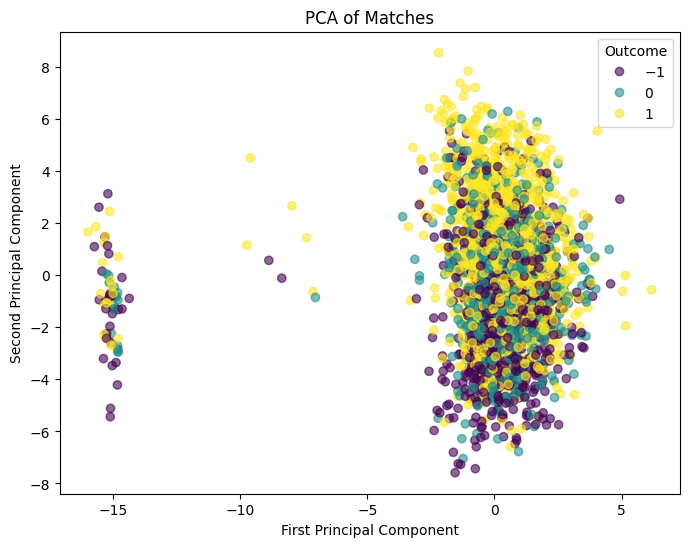

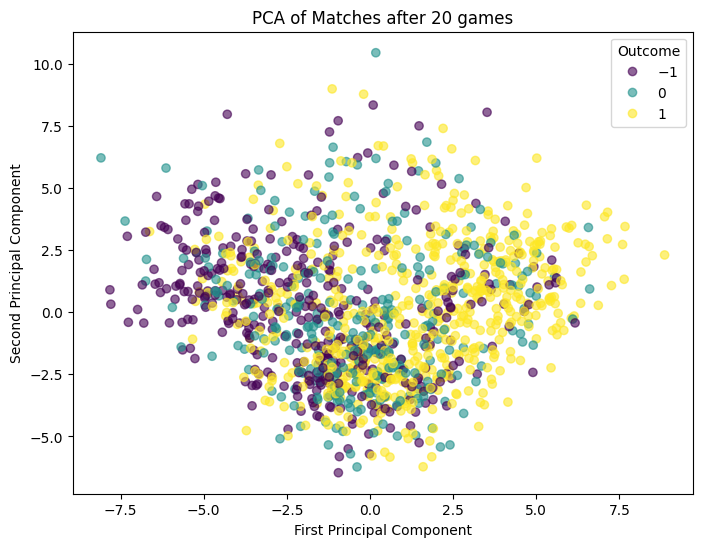

In [10]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap='viridis', alpha=0.6)
plt.title('PCA of Matches')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(*scatter.legend_elements(), title="Outcome")
plt.show()

pca20 = PCA(n_components=4)
X_train_pca20 = pca20.fit_transform(X_train_scaled20)
X_test_pca20 = pca20.transform(X_test_scaled20)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_train_pca20[:,0], X_train_pca20[:,1], c=y_train20, cmap='viridis', alpha=0.6)
plt.title('PCA of Matches after 20 games')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(*scatter.legend_elements(), title="Outcome")
plt.show()


# RBF Transform

Gamma: 0.001, Variance: 0.29774396923272384
Gamma: 0.001, Variance: 0.2802911107036692
Gamma: 0.002, Variance: 0.38933184479343025
Gamma: 0.002, Variance: 0.39018838755155993
Gamma: 0.003, Variance: 0.4040979111498188
Gamma: 0.003, Variance: 0.4220074099279092
Gamma: 0.004, Variance: 0.38735046904060805
Gamma: 0.004, Variance: 0.41817764271210445
Gamma: 0.005, Variance: 0.3584333149065835
Gamma: 0.005, Variance: 0.39766779178980355
Best gamma: 0.003, Highest variance: 0.4040979111498188
Best gamma for 20 games: 0.003, Highest variance: 0.4220074099279092


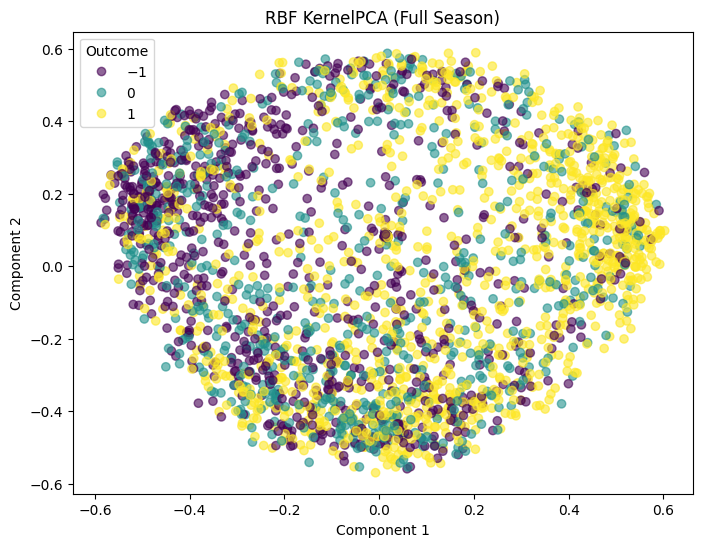

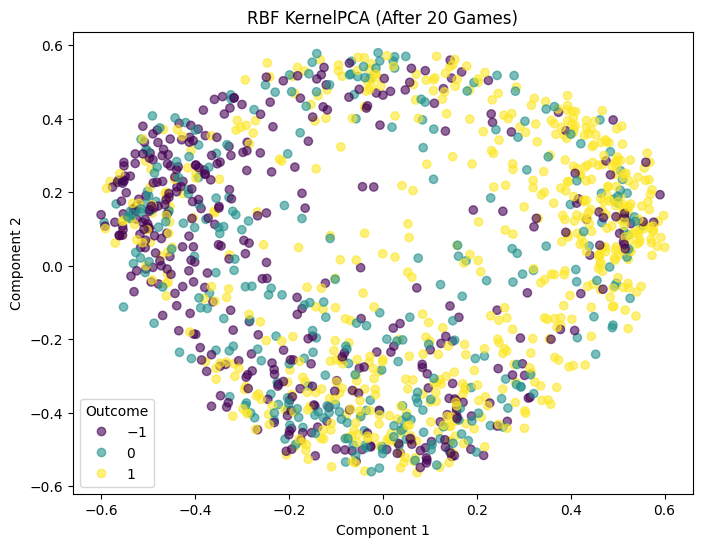

In [11]:
n_comp = 15
gammas = [0.001, 0.002, 0.003, 0.004, 0.005]

best_gamma = None
highest_variance = 0

best_gamma20 = None
highest_variance20 = 0

for gamma in gammas:
    kpca_rbf = KernelPCA(
        n_components=n_comp,
        kernel='rbf',
        gamma=gamma,
        fit_inverse_transform=False,
        random_state=42
    )
    X_train_rbf = kpca_rbf.fit_transform(X_train)
    variance = np.var(X_train_rbf, axis=0).sum()
    print(f"Gamma: {gamma}, Variance: {variance}")
    if variance > highest_variance:
        highest_variance = variance
        best_gamma = gamma
        
    X_train_rbf20 = kpca_rbf.fit_transform(X_train20)
    variance20 = np.var(X_train_rbf20, axis=0).sum()
    print(f"Gamma: {gamma}, Variance: {variance20}")
    if variance20 > highest_variance20:
        highest_variance20 = variance20
        best_gamma20 = gamma
        

print(f"Best gamma: {best_gamma}, Highest variance: {highest_variance}")
print(f"Best gamma for 20 games: {best_gamma20}, Highest variance: {highest_variance20}")

kpca_rbf = KernelPCA(
        n_components=n_comp,
        kernel='rbf',
        gamma=best_gamma,
        fit_inverse_transform=False,
        random_state=42
    )

X_train_rbf = kpca_rbf.fit_transform(X_train)
X_test_rbf = kpca_rbf.transform(X_test)

kpca_rbf20 = KernelPCA(
        n_components=n_comp,
        kernel='rbf',
        gamma=best_gamma20,
        fit_inverse_transform=False,
        random_state=42
    )

X_train_rbf20 = kpca_rbf.fit_transform(X_train20)
X_test_rbf20 = kpca_rbf.transform(X_test20)

#Full‐season RBF KernelPCA scatter
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_rbf[:, 0],
    X_train_rbf[:, 1],
    c=y_train,
    cmap='viridis',
    alpha=0.6
)
plt.title('RBF KernelPCA (Full Season)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements(), title="Outcome")
plt.show()

# “20 games” RBF KernelPCA scatter 
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_rbf20[:, 0],
    X_train_rbf20[:, 1],
    c=y_train20,
    cmap='viridis',
    alpha=0.6
)
plt.title('RBF KernelPCA (After 20 Games)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements(), title="Outcome")
plt.show()

# Polynomial Transformation of Degree 2

In [12]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print("Polynomial features shape:", X_train_poly.shape)

X_train_poly20 = poly.fit_transform(X_train_scaled20)
X_test_poly20 = poly.transform(X_test_scaled20)

print("Polynomial features shape:", X_train_poly20.shape)



Polynomial features shape: (2760, 779)
Polynomial features shape: (1305, 779)


# Logistic Regression

C	Train Acc (full)	Test Acc (full)	Train Acc (20)	Test Acc (20)
0.0001		0.5279		0.5408		0.5487		0.5230
0.0005		0.5315		0.5332		0.5548		0.5356
0.0010		0.5341		0.5332		0.5579		0.5356
0.0100		0.5308		0.5315		0.5579		0.5356
0.1000		0.5293		0.5255		0.5648		0.5287
1.0000		0.5286		0.5250		0.5563		0.5253


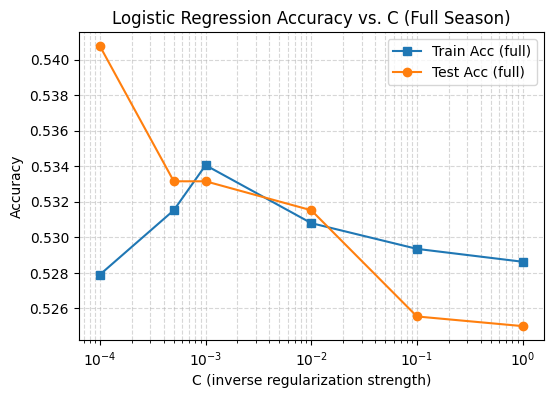

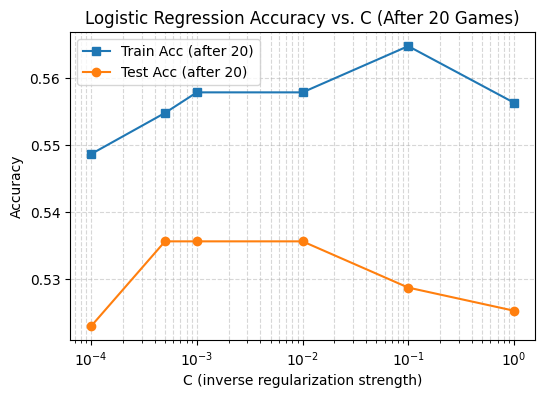

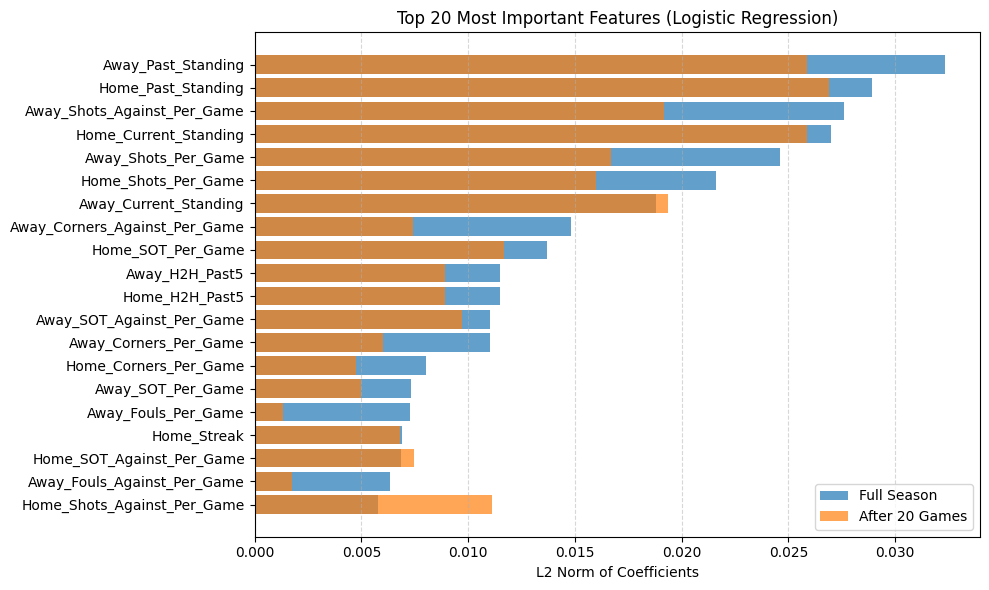

In [ ]:
C_values = [0.0001, 0.0005, 0.001, 0.01, 0.1, 1]

train_acc, test_acc = [], []
train_acc20, test_acc20 = [], []

print("C\tTrain Acc (full)\tTest Acc (full)\tTrain Acc (20)\tTest Acc (20)")
for C in C_values:
    # full‐data model
    model = LogisticRegression(C=C, penalty='l2', solver='lbfgs',
                               max_iter=3000, random_state=42)
    model.fit(X_train, y_train)
    train = accuracy_score(y_train, model.predict(X_train))
    test = accuracy_score(y_test,  model.predict(X_test))
    train_acc.append(train)
    test_acc.append(test)
    # after‐20 games model
    model20 = LogisticRegression(C=C, penalty='l2', solver='lbfgs',
                                 max_iter=3000, random_state=42)
    model20.fit(X_train20, y_train20)
    train20 = accuracy_score(y_train20, model20.predict(X_train20))
    test20 = accuracy_score(y_test20,  model20.predict(X_test20))
    train_acc20.append(train20)
    test_acc20.append(test20)
    
    if C == 0.0001: # Save model with best performing C
        model_full_final = model
        model_20_final = model20

    print(f"{C:.4f}\t\t{train:.4f}\t\t{test:.4f}\t\t{train20:.4f}\t\t{test20:.4f}")

# Plot full‐season accuracies
plt.figure(figsize=(6,4))
plt.plot(C_values, train_acc,  marker='s', label='Train Acc (full)')
plt.plot(C_values, test_acc,   marker='o', label='Test Acc (full)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs. C (Full Season)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# Plot after‐20 games accuracies
plt.figure(figsize=(6,4))
plt.plot(C_values, train_acc20, marker='s', label='Train Acc (after 20)')
plt.plot(C_values, test_acc20,  marker='o', label='Test Acc (after 20)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs. C (After 20 Games)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# Plot most important features using saved models
try:
    feature_names = X_train.columns.tolist()
except AttributeError:
    feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]

# Get L2 norm of coefficients
importance_full = np.linalg.norm(model_full_final.coef_, axis=0)
importance_20 = np.linalg.norm(model_20_final.coef_, axis=0)

# Sort by importance (from full model)
sorted_idx = np.argsort(importance_full)[::-1]
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importance_full = importance_full[sorted_idx]
sorted_importance_20 = importance_20[sorted_idx]

# Plot top N
N = 20
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:N][::-1], sorted_importance_full[:N][::-1], alpha=0.7, label='Full Season')
plt.barh(sorted_features[:N][::-1], sorted_importance_20[:N][::-1], alpha=0.7, label='After 20 Games')
plt.xlabel('L2 Norm of Coefficients')
plt.title(f'Top {N} Most Important Features (Logistic Regression)')
plt.legend()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Logistic Regression After PCA

C	Train Acc (full)	Test Acc (full)	Train Acc (20)	Test Acc (20)
0.0001	0.4982		0.5136		0.5042		0.4966
0.0005	0.5116		0.5429		0.5341		0.5322
0.0010	0.5123		0.5451		0.5479		0.5414
0.0100	0.5167		0.5429		0.5548		0.5391
0.1000	0.5156		0.5424		0.5540		0.5391
1.0000	0.5156		0.5429		0.5533		0.5391


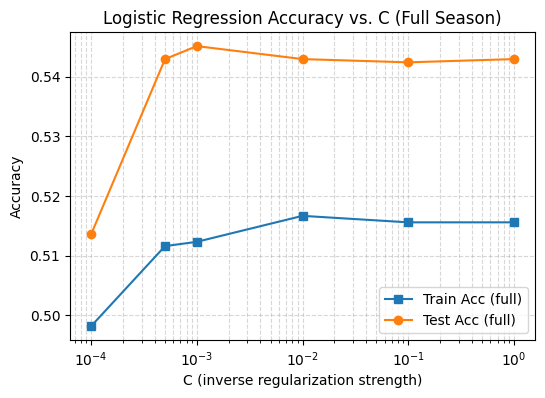

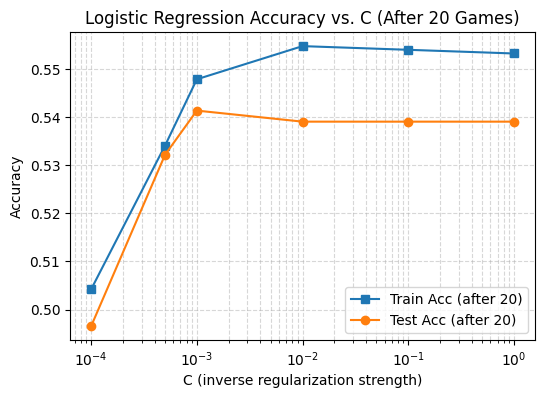

In [16]:
C_values = [0.0001, 0.0005, 0.001, 0.01, 0.1, 1]

train_acc, test_acc = [], []
train_acc20, test_acc20 = [], []

print("C\tTrain Acc (full)\tTest Acc (full)\tTrain Acc (20)\tTest Acc (20)")
for C in C_values:
    # full‐data model
    model = LogisticRegression(C=C, penalty='l2', solver='lbfgs',
                               max_iter=3000, random_state=42)
    model.fit(X_train_pca, y_train)
    train = accuracy_score(y_train, model.predict(X_train_pca))
    test = accuracy_score(y_test,  model.predict(X_test_pca))
    train_acc.append(train)
    test_acc.append(test)
    # after‐20 games model
    model20 = LogisticRegression(C=C, penalty='l2', solver='lbfgs',
                                 max_iter=3000, random_state=42)
    model20.fit(X_train_pca20, y_train20)
    train20 = accuracy_score(y_train20, model20.predict(X_train_pca20))
    test20 = accuracy_score(y_test20,  model20.predict(X_test_pca20))
    train_acc20.append(train20)
    test_acc20.append(test20)

    print(f"{C:.4f}\t{train:.4f}\t\t{test:.4f}\t\t{train20:.4f}\t\t{test20:.4f}")

# Plot full‐season accuracies
plt.figure(figsize=(6,4))
plt.plot(C_values, train_acc,  marker='s', label='Train Acc (full)')
plt.plot(C_values, test_acc,   marker='o', label='Test Acc (full)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs. C (Full Season)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# Plot after‐20 games accuracies
plt.figure(figsize=(6,4))
plt.plot(C_values, train_acc20, marker='s', label='Train Acc (after 20)')
plt.plot(C_values, test_acc20,  marker='o', label='Test Acc (after 20)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs. C (After 20 Games)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# Logistic Regression after Polynomial of degree 2

C	Train Acc (full)	Test Acc (full)	Train Acc (20)	Test Acc (20)
0.0001	0.5152		0.5114		0.5395		0.5253
0.0005	0.5656		0.5228		0.5923		0.5448
0.0010	0.5913		0.5234		0.6299		0.5356
0.0100	0.6601		0.4929		0.7448		0.4966
0.1000	0.7091		0.4533		0.8598		0.4770
1.0000	0.7322		0.4266		0.9770		0.4333


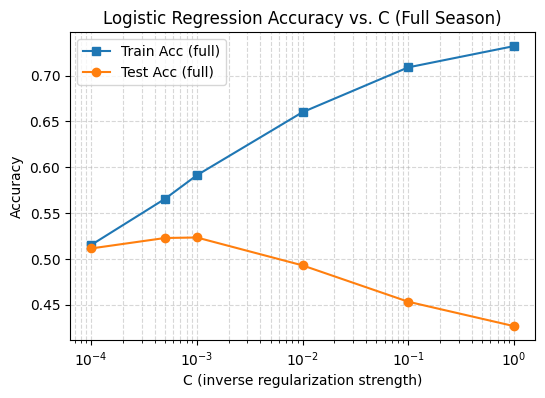

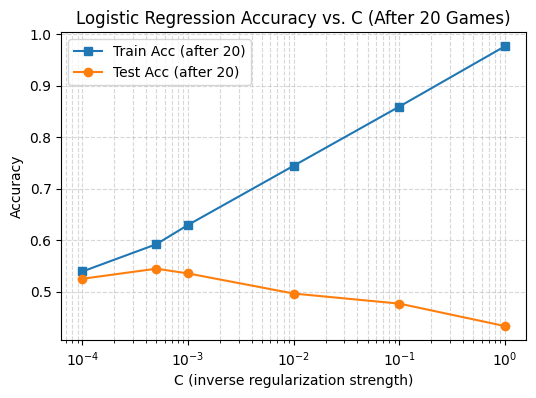

In [ ]:
# Cross-validation to find best C for Polynomial deg 2 -transformed data
C_values = [0.0001, 0.0005, 0.001, 0.01, 0.1, 1]

train_acc, test_acc = [], []
train_acc20, test_acc20 = [], []

print("C\tTrain Acc (full)\tTest Acc (full)\tTrain Acc (20)\tTest Acc (20)")
for c in C_values:
    # full‐data model
    model = LogisticRegression(C=c, penalty='l2', solver='lbfgs',
                               max_iter=3000, random_state=42)
    model.fit(X_train_poly, y_train)
    train = accuracy_score(y_train, model.predict(X_train_poly))
    test = accuracy_score(y_test,  model.predict(X_test_poly))
    train_acc.append(train)
    test_acc.append(test)
    # after‐20 games model
    model20 = LogisticRegression(C=c, penalty='l2', solver='lbfgs',
                                 max_iter=3000, random_state=42)
    model20.fit(X_train_poly20, y_train20)
    train20 = accuracy_score(y_train20, model20.predict(X_train_poly20))
    test20 = accuracy_score(y_test20,  model20.predict(X_test_poly20))
    train_acc20.append(train20)
    test_acc20.append(test20)

    print(f"{c:.4f}\t{train:.4f}\t\t{test:.4f}\t\t{train20:.4f}\t\t{test20:.4f}")
    
# Plot full‐season accuracies
plt.figure(figsize=(6,4))
plt.plot(C_values, train_acc,  marker='s', label='Train Acc (full)')
plt.plot(C_values, test_acc,   marker='o', label='Test Acc (full)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs. C (Full Season)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# Plot after‐20 games accuracies
plt.figure(figsize=(6,4))
plt.plot(C_values, train_acc20, marker='s', label='Train Acc (after 20)')
plt.plot(C_values, test_acc20,  marker='o', label='Test Acc (after 20)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs. C (After 20 Games)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# Logisistic Regression after RBF

C	Train Acc (full)	Test Acc (full)	Train Acc (20)	Test Acc (20)
0.0001	0.4496		0.4495		0.4690		0.4678
0.0005	0.4496		0.4495		0.4690		0.4678
0.0010	0.4496		0.4495		0.4690		0.4678
0.0100	0.5145		0.5190		0.4981		0.5000
0.1000	0.5293		0.5326		0.5494		0.5356
1.0000	0.5275		0.5293		0.5517		0.5356


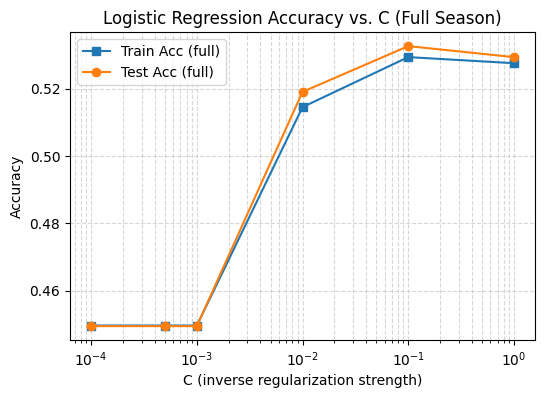

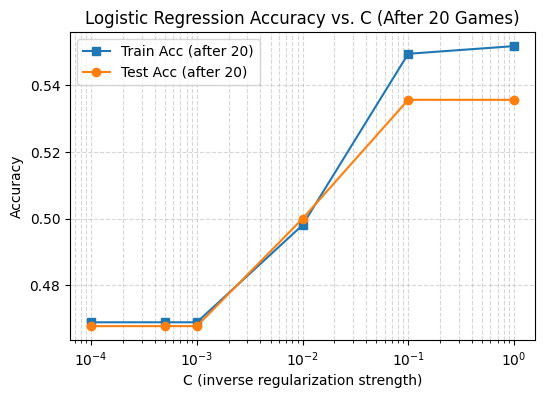

In [15]:
# Cross-validation to find best C for Polynomial deg 2 -transformed data
C_values = [0.0001, 0.0005, 0.001, 0.01, 0.1, 1]

train_acc, test_acc = [], []
train_acc20, test_acc20 = [], []

print("C\tTrain Acc (full)\tTest Acc (full)\tTrain Acc (20)\tTest Acc (20)")
for c in C_values:
    # full‐data model
    model = LogisticRegression(C=c, penalty='l2', solver='lbfgs',
                               max_iter=3000, random_state=42)
    model.fit(X_train_rbf, y_train)
    train = accuracy_score(y_train, model.predict(X_train_rbf))
    test = accuracy_score(y_test,  model.predict(X_test_rbf))
    train_acc.append(train)
    test_acc.append(test)
    # after‐20 games model
    model20 = LogisticRegression(C=c, penalty='l2', solver='lbfgs',
                                 max_iter=3000, random_state=42)
    model20.fit(X_train_rbf20, y_train20)
    train20 = accuracy_score(y_train20, model20.predict(X_train_rbf20))
    test20 = accuracy_score(y_test20,  model20.predict(X_test_rbf20))
    train_acc20.append(train20)
    test_acc20.append(test20)

    print(f"{c:.4f}\t{train:.4f}\t\t{test:.4f}\t\t{train20:.4f}\t\t{test20:.4f}")
    
# Plot full‐season accuracies
plt.figure(figsize=(6,4))
plt.plot(C_values, train_acc,  marker='s', label='Train Acc (full)')
plt.plot(C_values, test_acc,   marker='o', label='Test Acc (full)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs. C (Full Season)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# Plot after‐20 games accuracies
plt.figure(figsize=(6,4))
plt.plot(C_values, train_acc20, marker='s', label='Train Acc (after 20)')
plt.plot(C_values, test_acc20,  marker='o', label='Test Acc (after 20)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs. C (After 20 Games)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# Neural Network

Starting gradient descent for 2000 iterations
Iteration 0 of 2000
Iteration 250 of 2000
Iteration 500 of 2000
Iteration 750 of 2000
Iteration 1000 of 2000
Iteration 1250 of 2000
Iteration 1500 of 2000
Iteration 1750 of 2000


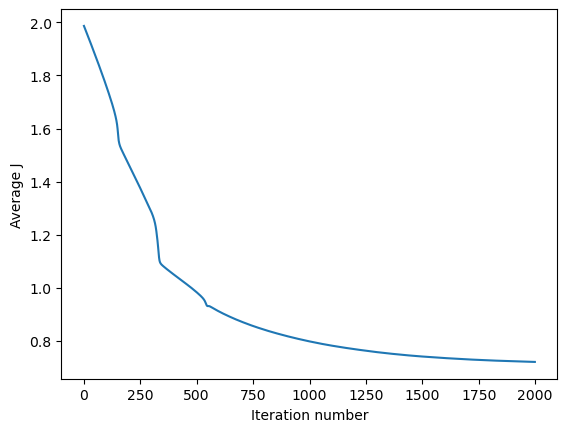

alpha = 0.2
Training accuracy is 56.24521072796935%
Prediction accuracy is 53.9080459770115%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 250 of 3000
Iteration 500 of 3000
Iteration 750 of 3000
Iteration 1000 of 3000
Iteration 1250 of 3000
Iteration 1500 of 3000
Iteration 1750 of 3000
Iteration 2000 of 3000
Iteration 2250 of 3000
Iteration 2500 of 3000
Iteration 2750 of 3000


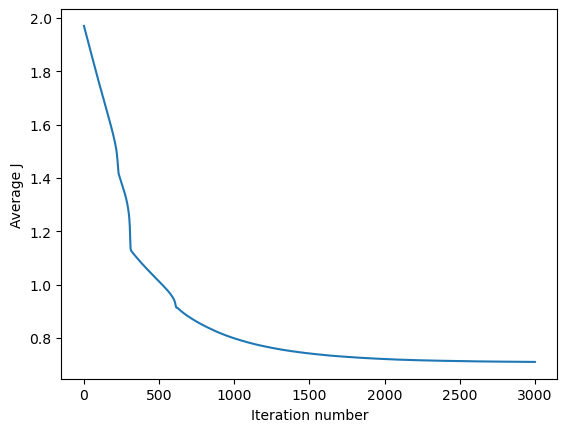

alpha = 0.2
Training accuracy is 56.85823754789272%
Prediction accuracy is 53.67816091954023%
Starting gradient descent for 5000 iterations
Iteration 0 of 5000
Iteration 250 of 5000
Iteration 500 of 5000
Iteration 750 of 5000
Iteration 1000 of 5000
Iteration 1250 of 5000
Iteration 1500 of 5000
Iteration 1750 of 5000
Iteration 2000 of 5000
Iteration 2250 of 5000
Iteration 2500 of 5000
Iteration 2750 of 5000
Iteration 3000 of 5000
Iteration 3250 of 5000
Iteration 3500 of 5000
Iteration 3750 of 5000
Iteration 4000 of 5000
Iteration 4250 of 5000
Iteration 4500 of 5000
Iteration 4750 of 5000


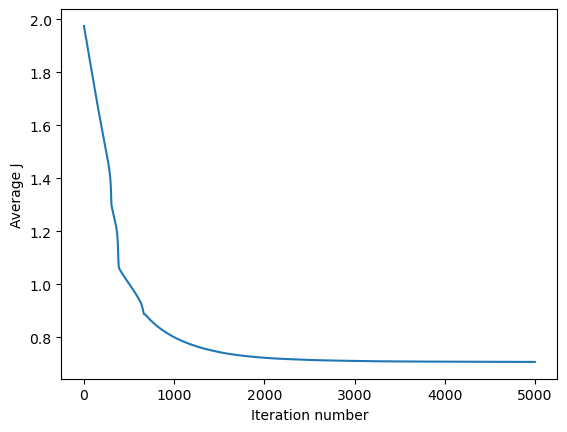

alpha = 0.2
Training accuracy is 57.39463601532567%
Prediction accuracy is 54.137931034482754%
Starting gradient descent for 10000 iterations
Iteration 0 of 10000
Iteration 250 of 10000
Iteration 500 of 10000
Iteration 750 of 10000
Iteration 1000 of 10000
Iteration 1250 of 10000
Iteration 1500 of 10000
Iteration 1750 of 10000
Iteration 2000 of 10000
Iteration 2250 of 10000
Iteration 2500 of 10000
Iteration 2750 of 10000
Iteration 3000 of 10000
Iteration 3250 of 10000
Iteration 3500 of 10000
Iteration 3750 of 10000
Iteration 4000 of 10000
Iteration 4250 of 10000
Iteration 4500 of 10000
Iteration 4750 of 10000
Iteration 5000 of 10000
Iteration 5250 of 10000
Iteration 5500 of 10000
Iteration 5750 of 10000
Iteration 6000 of 10000
Iteration 6250 of 10000
Iteration 6500 of 10000
Iteration 6750 of 10000
Iteration 7000 of 10000
Iteration 7250 of 10000
Iteration 7500 of 10000
Iteration 7750 of 10000
Iteration 8000 of 10000
Iteration 8250 of 10000
Iteration 8500 of 10000
Iteration 8750 of 10000


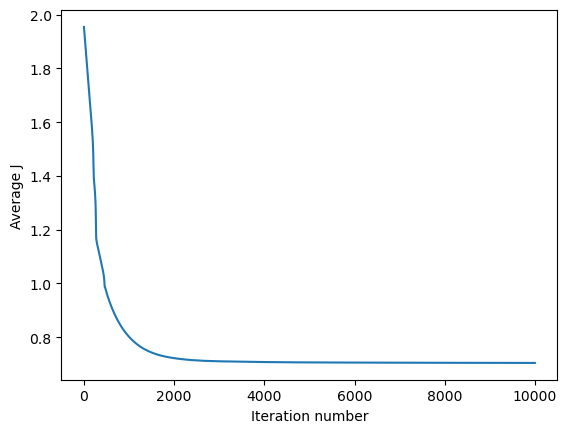

alpha = 0.2
Training accuracy is 57.8544061302682%
Prediction accuracy is 53.44827586206896%


In [ ]:

data = np.loadtxt('dataafter20.csv',delimiter=',',skiprows=1)

X = data[:, :-1].astype(float)    
y_raw = data[:,  -1].astype(int)

# 2) Remap labels from {-1,0,1} → {0,1,2}
y = y_raw + 1                      

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 3))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4)

y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)


def sig(z):
    return 1 / (1 + np.exp(-z))

def sig_deriv(z):
    return sig(z) * (1 - sig(z))

def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return np.where(z > 0, 1, 0)    

def tanh(z):
    return np.tanh(z)

def tanh_deriv(z):
    return 1 - np.tanh(z)**2

def elu(z, alpha=1.0):
    return np.where(z >= 0, z, alpha * (np.exp(z) - 1))

def elu_deriv(z, alpha=1.0):
    return np.where(z >= 0, 1, elu(z, alpha) + alpha)

activation = relu
activation_deriv = relu_deriv
output = sig
output_deriv = sig_deriv

def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        if l == len(W):
            a[l+1] = output(z[l+1])   # use sigmoid only for output
        else:
            a[l+1] = activation(z[l+1]) # a^(l+1) = f(z^(l+1))

    return a, z

def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * output_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * activation_deriv(z_l)

def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.2, lam=0.005):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))

    while cnt < iter_num:
        if cnt % 250 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))

        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0

        for i in range(N):
            delta = {}
            # Forward pass
            a, z = feed_forward(X[i, :], W, b)

            # Backward pass
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i, :], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i, :] - a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l + 1], W[l], z[l])

                    # Gradient accumulation + L2 regularization
                    tri_W[l] += np.dot(delta[l + 1][:, np.newaxis], np.transpose(a[l][:, np.newaxis])) + lam * W[l]
                    tri_b[l] += delta[l + 1]  # No regularization for biases

        # Gradient descent update
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0 / N * tri_W[l])
            b[l] += -alpha * (1.0 / N * tri_b[l])

        # Cost with L2 regularization
        avg_cost = 1.0 / N * avg_cost
        reg_term = 0.5 * lam * sum(np.sum(W[l]**2) for l in W)
        avg_cost += reg_term

        avg_cost_func.append(avg_cost)
        cnt += 1

    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

nn_structure = [38,20,3]
    
# train the NN
iters = [5000]

for l in iters:
    W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, l)
    # plot the avg_cost_func
    plt.plot(avg_cost_func)
    plt.ylabel('Average J')
    plt.xlabel('Iteration number')
    plt.show()

    # get the prediction accuracy and print

    y_pred = predict_y(W, b, X_test, 3)
    y_pred_train = predict_y(W, b, X_train, 3)
    print("alpha = {}".format(a))
    print('Training accuracy is {}%'.format(accuracy_score(y_train,y_pred_train) * 100))
    print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

# Neural Network using scikit-learn

[Full data] Best a = 0.01 → test accuracy = 53.86%


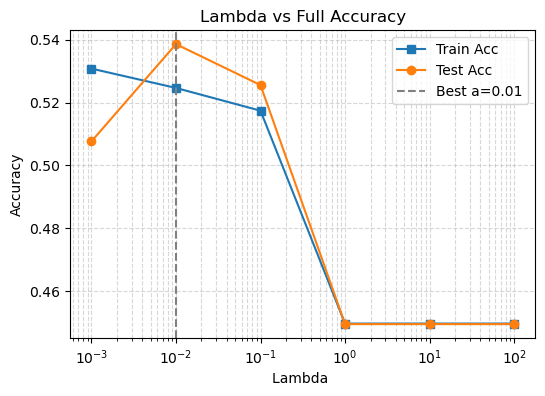


[Full data] Classification report:
              precision    recall  f1-score   support

          -1       0.50      0.57      0.53       557
           0       0.00      0.00      0.00       456
           1       0.56      0.82      0.66       827

    accuracy                           0.54      1840
   macro avg       0.35      0.46      0.40      1840
weighted avg       0.40      0.54      0.46      1840



c:\Users\Andy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Andy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Andy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


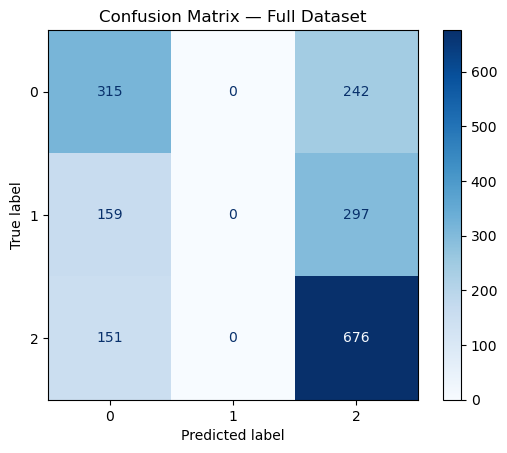

[20-match data] Best a = 1 → test accuracy = 53.68%


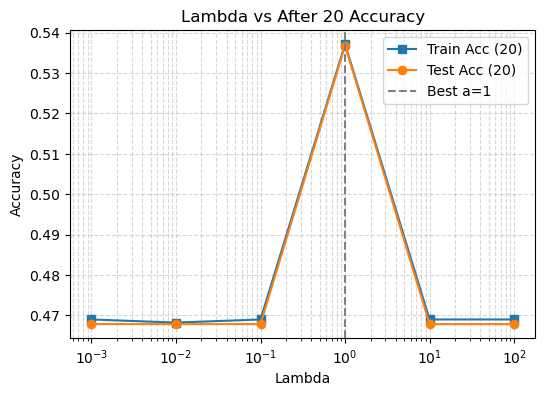


[20-match data] Classification report:
              precision    recall  f1-score   support

          -1       0.53      0.40      0.46       258
           0       0.00      0.00      0.00       205
           1       0.54      0.89      0.67       407

    accuracy                           0.54       870
   macro avg       0.36      0.43      0.38       870
weighted avg       0.41      0.54      0.45       870



c:\Users\Andy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Andy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Andy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


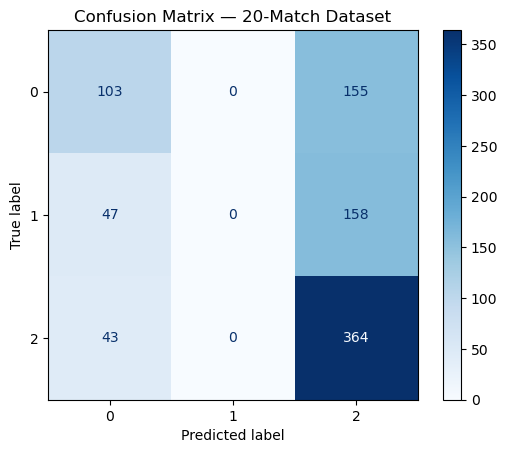

In [76]:
# Define the regularization strengths to sweep
a_list = [0.001, 0.01, 0.1, 1, 10, 100]
activation = 'logistic'
activation2 = 'relu'
hidden_layer = (25,20)
# Sweep on the full dataset
train_acc = []
test_acc  = []

for a in a_list:
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer,
        activation=activation,
        solver='adam',
        alpha=a,                    
        batch_size=64,
        learning_rate='constant',
        learning_rate_init=0.2,
        max_iter=5000,
        early_stopping=False,
        random_state=42
    )
    mlp.fit(X_train_scaled, y_train)

    train_acc.append(accuracy_score(y_train, mlp.predict(X_train_scaled)))
    test_acc.append( accuracy_score(y_test,  mlp.predict(X_test_scaled)) )

best_idx = np.argmax(test_acc)
best_a   = a_list[best_idx]
best_score = test_acc[best_idx]

print(f"[Full data] Best a = {best_a} → test accuracy = {best_score*100:.2f}%")

plt.figure(figsize=(6,4))
plt.plot(a_list, train_acc, marker='s', label='Train Acc')
plt.plot(a_list, test_acc,  marker='o', label='Test Acc')
plt.xscale('log')
plt.axvline(best_a, color='gray', linestyle='--', label=f'Best a={best_a}')
plt.title('Lambda vs Full Accuracy')
plt.xlabel('Lambda ')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()


# Final full-dataset model & confusion matrix
mlp = MLPClassifier(
    hidden_layer_sizes=hidden_layer,
    activation=activation,
    solver='adam',
    alpha=best_a,                
    batch_size=64,
    learning_rate='constant',
    learning_rate_init=0.2,
    max_iter=5000,
    early_stopping=False,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)
print("\n[Full data] Classification report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix — Full Dataset")
plt.show()



#Sweep on the 20-match dataset
train_acc20 = []
test_acc20  = []

for a in a_list:
    mlp20 = MLPClassifier(
        hidden_layer_sizes=hidden_layer,
        activation=activation2,
        solver='adam',
        alpha=a,                   
        batch_size=64,
        learning_rate='adaptive',
        learning_rate_init=0.2,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    mlp20.fit(X_train_scaled20, y_train20)

    train_acc20.append(accuracy_score(y_train20, mlp20.predict(X_train_scaled20)))
    test_acc20.append( accuracy_score(y_test20,  mlp20.predict(X_test_scaled20)) )

best_idx20 = np.argmax(test_acc20)
best_a20   = a_list[best_idx20]
best_score20 = test_acc20[best_idx20]

print(f"[20-match data] Best a = {best_a20} → test accuracy = {best_score20*100:.2f}%")

plt.figure(figsize=(6,4))
plt.plot(a_list, train_acc20, marker='s', label='Train Acc (20)')
plt.plot(a_list, test_acc20,  marker='o', label='Test Acc (20)')
plt.xscale('log')
plt.axvline(best_a20, color='gray', linestyle='--', label=f'Best a={best_a20}')
plt.title('Lambda vs After 20 Accuracy')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()


#Final 20-match model & confusion matrix
mlp20 = MLPClassifier(
    hidden_layer_sizes=hidden_layer,
    activation=activation2,
    solver='adam',
    alpha=best_a20,              
    batch_size=64,
    learning_rate='adaptive',
    learning_rate_init=0.2,
    max_iter=500,
    early_stopping=True,
    random_state=42
)
mlp20.fit(X_train_scaled20, y_train20)

y_pred20 = mlp20.predict(X_test_scaled20)
print("\n[20-match data] Classification report:")
print(classification_report(y_test20, y_pred20))

cm20 = confusion_matrix(y_test20, y_pred20)
disp20 = ConfusionMatrixDisplay(confusion_matrix=cm20)
disp20.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix — 20-Match Dataset")
plt.show()

# SVM

C	Train Acc (full)	Test Acc (full)	Train Acc (20)	Test Acc (20)
0.0001	0.5101		0.5272		0.5379		0.5184
0.0005	0.5138		0.5332		0.5441		0.5184
0.0010	0.5246		0.5348		0.5441		0.5253
0.0050	0.5149		0.5321		0.5341		0.5253
0.0100	0.5159		0.4989		0.5080		0.5023
0.0500	0.5261		0.5277		0.5211		0.4805
0.1000	0.4804		0.4837		0.5257		0.5172
0.5000	0.3924		0.3951		0.4935		0.4448
1.0000	0.4380		0.4332		0.3686		0.3483
5.0000	0.3199		0.3201		0.4291		0.4172


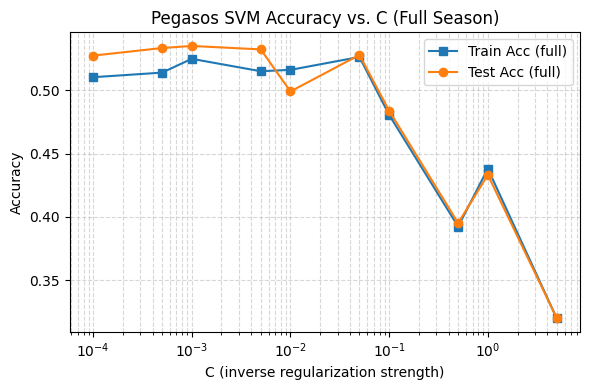

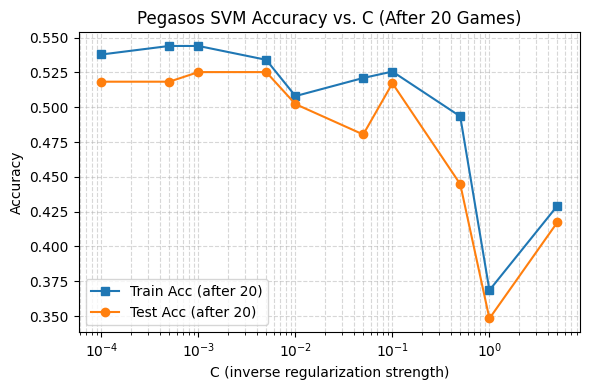

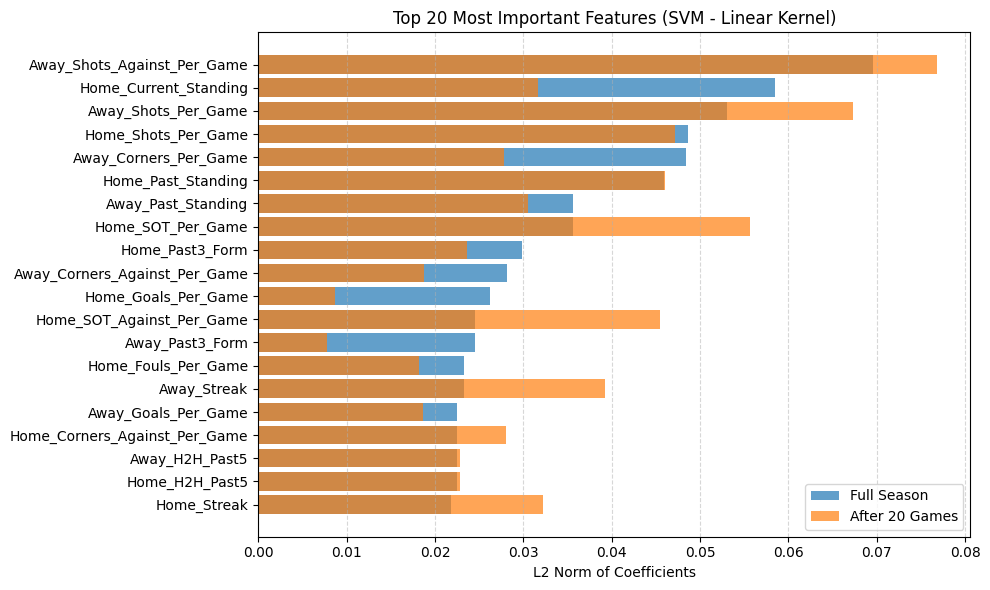

In [ ]:
C_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]

train_acc, test_acc = [], []
train_acc20, test_acc20 = [], []

print("C\tTrain Acc (full)\tTest Acc (full)\tTrain Acc (20)\tTest Acc (20)")

for C in C_values:
    # Compute alpha from C
    alpha_full = 1 / (len(y_train) * C)
    alpha_20   = 1 / (len(y_train20) * C)

    # Full season
    model = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_full,
                          max_iter=1000, tol=1e-3, random_state=42)
    model.fit(X_train, y_train)
    train = accuracy_score(y_train, model.predict(X_train))
    test = accuracy_score(y_test,  model.predict(X_test))
    train_acc.append(train)
    test_acc.append(test)

    # After 20 games
    model20 = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_20,
                            max_iter=1000, tol=1e-3, random_state=42)
    model20.fit(X_train20, y_train20)
    train20 = accuracy_score(y_train20, model20.predict(X_train20))
    test20 = accuracy_score(y_test20,  model20.predict(X_test20))
    train_acc20.append(train20)
    test_acc20.append(test20)
    
    if C == 0.001: # Save the model with C=0.001 (best performing) for later use
        svc_full_final = model
        svc_20_final = model20

    print(f"{C:.4f}\t{train:.4f}\t\t{test:.4f}\t\t{train20:.4f}\t\t{test20:.4f}")

# Full season
plt.figure(figsize=(6, 4))
plt.plot(C_values, train_acc,  marker='s', label='Train Acc (full)')
plt.plot(C_values, test_acc,   marker='o', label='Test Acc (full)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Pegasos SVM Accuracy vs. C (Full Season)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# After 20 games
plt.figure(figsize=(6, 4))
plt.plot(C_values, train_acc20, marker='s', label='Train Acc (after 20)')
plt.plot(C_values, test_acc20,  marker='o', label='Test Acc (after 20)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Pegasos SVM Accuracy vs. C (After 20 Games)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

try:
    feature_names = X_train.columns.tolist()
except AttributeError:
    feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]

# Get L2 norm of coefficients
importance_full = np.linalg.norm(svc_full_final.coef_, axis=0)
importance_20 = np.linalg.norm(svc_20_final.coef_, axis=0)

# Sort features by importance in full model
sorted_idx = np.argsort(importance_full)[::-1]
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importance_full = importance_full[sorted_idx]
sorted_importance_20 = importance_20[sorted_idx]

# Plot top N
N = 20
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:N][::-1], sorted_importance_full[:N][::-1], alpha=0.7, label='Full Season')
plt.barh(sorted_features[:N][::-1], sorted_importance_20[:N][::-1], alpha=0.7, label='After 20 Games')
plt.xlabel('L2 Norm of Coefficients')
plt.title(f'Top {N} Most Important Features (SVM - Linear Kernel)')
plt.legend()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# SVM After PCA

C	Train Acc (full)	Test Acc (full)	Train Acc (20)	Test Acc (20)
0.0001	0.4866		0.5060		0.4690		0.4678
0.0005	0.5036		0.5315		0.5188		0.5207
0.0010	0.5062		0.5315		0.5287		0.5264
0.0050	0.5094		0.5337		0.5364		0.5333
0.0100	0.5116		0.5386		0.5326		0.5368
0.0500	0.5047		0.5255		0.5402		0.5276
0.1000	0.5069		0.5332		0.5525		0.5333
0.5000	0.5076		0.5310		0.5402		0.5310
1.0000	0.5029		0.5293		0.5272		0.5126
5.0000	0.4667		0.4886		0.5011		0.5046


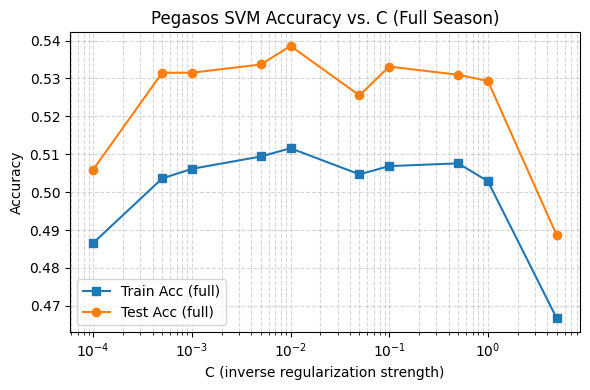

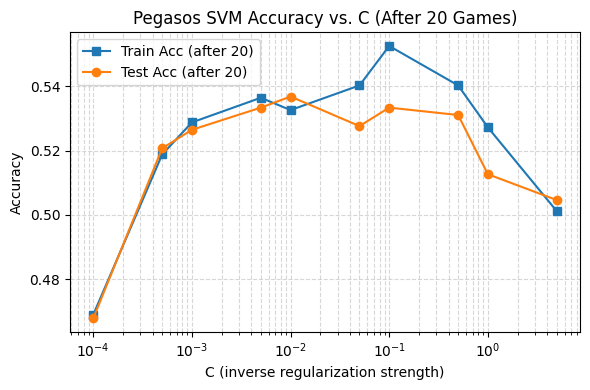

In [11]:
C_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]

train_acc, test_acc = [], []
train_acc20, test_acc20 = [], []

print("C\tTrain Acc (full)\tTest Acc (full)\tTrain Acc (20)\tTest Acc (20)")

for C in C_values:
    # Compute alpha from C
    alpha_full = 1 / (len(y_train) * C)
    alpha_20   = 1 / (len(y_train20) * C)

    # Full season
    model = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_full,
                          max_iter=1000, tol=1e-3, random_state=42)
    model.fit(X_train_pca, y_train)
    train = accuracy_score(y_train, model.predict(X_train_pca))
    test = accuracy_score(y_test,  model.predict(X_test_pca))
    train_acc.append(train)
    test_acc.append(test)

    # After 20 games
    model20 = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_20,
                            max_iter=1000, tol=1e-3, random_state=42)
    model20.fit(X_train_pca20, y_train20)
    train20 = accuracy_score(y_train20, model20.predict(X_train_pca20))
    test20 = accuracy_score(y_test20,  model20.predict(X_test_pca20))
    train_acc20.append(train20)
    test_acc20.append(test20)

    print(f"{C:.4f}\t{train:.4f}\t\t{test:.4f}\t\t{train20:.4f}\t\t{test20:.4f}")

# Full season
plt.figure(figsize=(6, 4))
plt.plot(C_values, train_acc,  marker='s', label='Train Acc (full)')
plt.plot(C_values, test_acc,   marker='o', label='Test Acc (full)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Pegasos SVM Accuracy vs. C (Full Season)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# After 20 games
plt.figure(figsize=(6, 4))
plt.plot(C_values, train_acc20, marker='s', label='Train Acc (after 20)')
plt.plot(C_values, test_acc20,  marker='o', label='Test Acc (after 20)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Pegasos SVM Accuracy vs. C (After 20 Games)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# SVM After Degree 2 Polynomial Transform

C	Train Acc (full)	Test Acc (full)	Train Acc (20)	Test Acc (20)
0.0001	0.5344		0.5179		0.5234		0.5172
0.0005	0.5612		0.5207		0.5793		0.5425
0.0010	0.5812		0.5174		0.6276		0.5391
0.0050	0.6377		0.4913		0.7280		0.5126
0.0100	0.6591		0.4777		0.7617		0.4874
0.0500	0.6714		0.4451		0.8077		0.4954
0.1000	0.6540		0.4516		0.8161		0.4759
0.5000	0.6301		0.4266		0.8107		0.4816
1.0000	0.6210		0.3935		0.8138		0.4609
5.0000	0.6178		0.4630		0.8107		0.4770


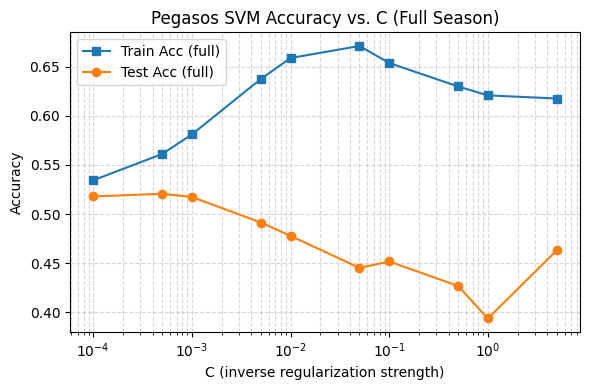

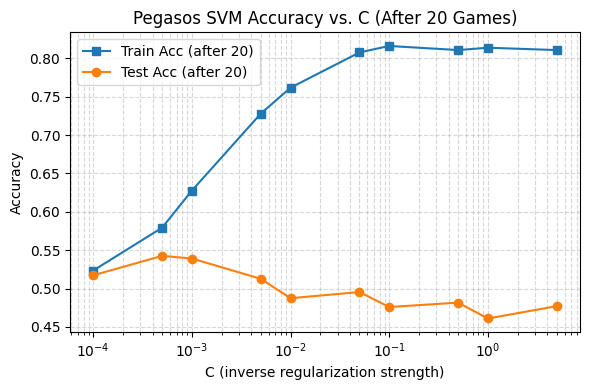

In [12]:
C_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]

train_acc, test_acc = [], []
train_acc20, test_acc20 = [], []

print("C\tTrain Acc (full)\tTest Acc (full)\tTrain Acc (20)\tTest Acc (20)")

for C in C_values:
    # Compute alpha from C
    alpha_full = 1 / (len(y_train) * C)
    alpha_20   = 1 / (len(y_train20) * C)

    # Full season
    model = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_full,
                          max_iter=1000, tol=1e-3, random_state=42)
    model.fit(X_train_poly, y_train)
    train = accuracy_score(y_train, model.predict(X_train_poly))
    test = accuracy_score(y_test,  model.predict(X_test_poly))
    train_acc.append(train)
    test_acc.append(test)

    # After 20 games
    model20 = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_20,
                            max_iter=1000, tol=1e-3, random_state=42)
    model20.fit(X_train_poly20, y_train20)
    train20 = accuracy_score(y_train20, model20.predict(X_train_poly20))
    test20 = accuracy_score(y_test20,  model20.predict(X_test_poly20))
    train_acc20.append(train20)
    test_acc20.append(test20)

    print(f"{C:.4f}\t{train:.4f}\t\t{test:.4f}\t\t{train20:.4f}\t\t{test20:.4f}")

# Full season
plt.figure(figsize=(6, 4))
plt.plot(C_values, train_acc,  marker='s', label='Train Acc (full)')
plt.plot(C_values, test_acc,   marker='o', label='Test Acc (full)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Pegasos SVM Accuracy vs. C (Full Season)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# After 20 games
plt.figure(figsize=(6, 4))
plt.plot(C_values, train_acc20, marker='s', label='Train Acc (after 20)')
plt.plot(C_values, test_acc20,  marker='o', label='Test Acc (after 20)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Pegasos SVM Accuracy vs. C (After 20 Games)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# SVM After RBF

C	Train Acc (full)	Test Acc (full)	Train Acc (20)	Test Acc (20)
0.0001	0.4496		0.4495		0.4690		0.4678
0.0005	0.4978		0.5011		0.4690		0.4678
0.0010	0.4982		0.5016		0.4690		0.4678
0.0050	0.4949		0.5060		0.5027		0.4977
0.0100	0.4967		0.5033		0.5027		0.4977
0.0500	0.5127		0.5239		0.5341		0.5253
0.1000	0.5116		0.5190		0.5479		0.5218
0.5000	0.5283		0.5359		0.5494		0.5402
1.0000	0.5232		0.5337		0.5402		0.5356
5.0000	0.4996		0.4995		0.5479		0.5264


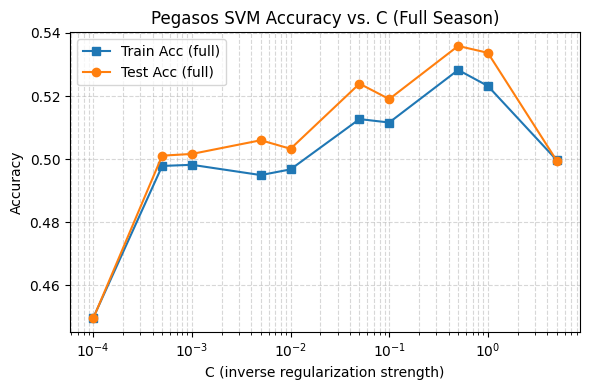

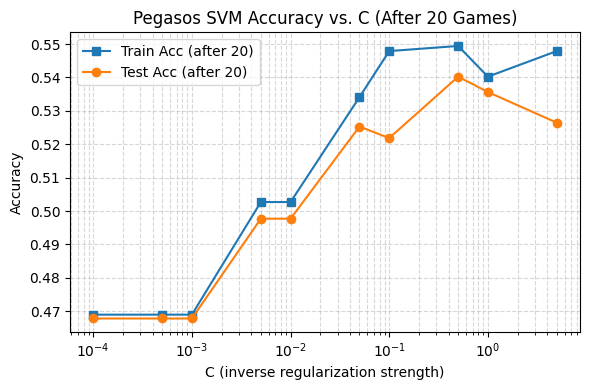

In [13]:
C_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]

train_acc, test_acc = [], []
train_acc20, test_acc20 = [], []

print("C\tTrain Acc (full)\tTest Acc (full)\tTrain Acc (20)\tTest Acc (20)")

for C in C_values:
    # Compute alpha from C
    alpha_full = 1 / (len(y_train) * C)
    alpha_20   = 1 / (len(y_train20) * C)

    # Full season
    model = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_full,
                          max_iter=1000, tol=1e-3, random_state=42)
    model.fit(X_train_rbf, y_train)
    train = accuracy_score(y_train, model.predict(X_train_rbf))
    test = accuracy_score(y_test,  model.predict(X_test_rbf))
    train_acc.append(train)
    test_acc.append(test)

    # After 20 games
    model20 = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha_20,
                            max_iter=1000, tol=1e-3, random_state=42)
    model20.fit(X_train_rbf20, y_train20)
    train20 = accuracy_score(y_train20, model20.predict(X_train_rbf20))
    test20 = accuracy_score(y_test20,  model20.predict(X_test_rbf20))
    train_acc20.append(train20)
    test_acc20.append(test20)

    print(f"{C:.4f}\t{train:.4f}\t\t{test:.4f}\t\t{train20:.4f}\t\t{test20:.4f}")

# Full season
plt.figure(figsize=(6, 4))
plt.plot(C_values, train_acc,  marker='s', label='Train Acc (full)')
plt.plot(C_values, test_acc,   marker='o', label='Test Acc (full)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Pegasos SVM Accuracy vs. C (Full Season)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# After 20 games
plt.figure(figsize=(6, 4))
plt.plot(C_values, train_acc20, marker='s', label='Train Acc (after 20)')
plt.plot(C_values, test_acc20,  marker='o', label='Test Acc (after 20)')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.title('Pegasos SVM Accuracy vs. C (After 20 Games)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()